In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import optax
from datetime import datetime

from water_balance_jax import wbm_jax, construct_Kpet_vec
from initial_params import initial_params, constants

### Preliminaries

In [2]:
#####################
#### Directories ####
#####################
project_data_path = "/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA"

In [3]:
def read_inputs(subset_name, obs_name, remove_nans):
    ######################
    # Read obs
    obs = np.load(f'{project_data_path}/WBM/precalibration/{subset_name}/{obs_name}/{obs_name}_validation.npy')

    ######################
    # Read and extract inputs
    npz = np.load(f"{project_data_path}/WBM/precalibration/{subset_name}/{obs_name}/inputs.npz")

    # Meteo forcing
    tas = npz['tas']
    prcp = npz['prcp']

    # LAI
    lai = npz['lai']

    # Soil properties
    awCap = npz['awCap']
    wiltingp = npz['wiltingp']
    clayfrac = npz['clayfrac']
    sandfrac = npz['sandfrac']
    siltfrac = npz['siltfrac']

    # Land use
    corn = npz['corn']
    cotton = npz['cotton']
    rice = npz['rice']
    sorghum = npz['sorghum']
    soybeans = npz['soybeans']
    durum_wheat = npz['durum_wheat']
    spring_wheat = npz['spring_wheat']
    winter_wheat = npz['winter_wheat']
    wheat = durum_wheat + spring_wheat + winter_wheat
    
    cropland_other = npz['cropland_other']
    water = npz['water']
    evergreen_needleleaf = npz['evergreen_needleleaf']
    evergreen_broadleaf = npz['evergreen_broadleaf']
    deciduous_needleleaf = npz['deciduous_needleleaf']
    deciduous_broadleaf = npz['deciduous_broadleaf']
    mixed_forest = npz['mixed_forest']
    woodland = npz['woodland']
    wooded_grassland = npz['wooded_grassland']
    closed_shurbland = npz['closed_shurbland']
    open_shrubland = npz['open_shrubland']
    grassland = npz['grassland']
    barren = npz['barren']
    urban = npz['urban']
    
    all_other = cropland_other + water + evergreen_needleleaf + evergreen_broadleaf + deciduous_needleleaf + deciduous_broadleaf + mixed_forest + woodland + wooded_grassland + closed_shurbland + open_shrubland + grassland + barren + urban
    
    # Geophysical
    elev_std = npz['elev_std']
    
    lats = npz['lats']
    lons = npz['lons']
    
    # Initial conditions
    Ws_init = npz['soilMoist_init']

    ##########################
    # Prepare inputs for vmap:
    # spatial dimensions need to be collapsed and first
    # NaN gridpoints need to be removed
    nx = tas.shape[0]
    ny = tas.shape[1]
    nt = tas.shape[2]

    assert nt % 365 == 0
    nyrs = int(nt / 365)

    ## Obs
    ys = obs.reshape(nx * ny, nt)
    nan_inds_obs = jnp.isnan(ys).any(axis=1)

    ## Forcing: all days
    tas_in = tas.reshape(nx * ny, nt)
    prcp_in = prcp.reshape(nx * ny, nt)

    x_forcing_nt = jnp.stack([tas_in, prcp_in], axis=1)
    nan_inds_forcing_nt = jnp.isnan(x_forcing_nt).any(axis=(1,2))

    ## Forcing: yearly
    lai_in = lai.reshape(nx * ny, 365)
    x_forcing_nyrs = lai_in
    nan_inds_forcing_nyrs = jnp.isnan(x_forcing_nyrs).any(axis=1)

    ## Maps
    awCap_in = awCap.reshape(nx * ny)
    wiltingp_in = wiltingp.reshape(nx * ny)

    Ws_init_in = Ws_init.reshape(nx * ny)

    clayfrac_in = clayfrac.reshape(nx * ny)
    sandfrac_in = sandfrac.reshape(nx * ny)
    siltfrac_in = siltfrac.reshape(nx * ny)

    lats_in = np.tile(lats, nx)
    elev_std_in = elev_std.reshape(nx * ny)

    corn_in = corn.reshape(nx * ny)
    cotton_in = cotton.reshape(nx * ny)
    rice_in = rice.reshape(nx * ny)
    sorghum_in = sorghum.reshape(nx * ny)
    soybeans_in = soybeans.reshape(nx * ny)
    wheat_in = wheat.reshape(nx * ny)

    all_other_in = all_other.reshape(nx * ny)

    x_maps = jnp.stack([awCap_in, wiltingp_in, 
                        Ws_init_in, 
                        clayfrac_in, sandfrac_in, siltfrac_in, 
                        lats_in, elev_std_in,
                        corn_in, cotton_in, rice_in, sorghum_in, soybeans_in, wheat_in],
                       axis=1)
    nan_inds_maps = jnp.isnan(x_maps).any(axis=1)

    # Remove NaNs if desired
    if remove_nans:
        nan_inds = nan_inds_obs + nan_inds_forcing_nt + nan_inds_forcing_nyrs + nan_inds_maps
        ys = ys[~nan_inds]
        x_forcing_nt = x_forcing_nt[~nan_inds]
        x_forcing_nyrs = x_forcing_nyrs[~nan_inds]
        x_maps = x_maps[~nan_inds]

    # Return
    return ys, x_forcing_nt, x_forcing_nyrs, x_maps

In [4]:
def make_prediction(theta, constants, x_forcing_nt, x_forcing_nyrs, x_maps):
    # Read inputs
    tas, prcp = x_forcing_nt
    lai = x_forcing_nyrs
    
    awCap, wiltingp, \
    Ws_init, \
    clayfrac, sandfrac, siltfrac, \
    lats, elev_std, \
    corn, cotton, rice, sorghum, soybeans, wheat \
    = x_maps

    # Define all constants
    Ts, Tm, Wi_init, Sp_init = constants 
    
    # Define all params
    awCap_scalar, wiltingp_scalar, \
    alpha_claycoef, alpha_sandcoef, alpha_siltcoef, \
    betaHBV_claycoef, betaHBV_sandcoef, betaHBV_siltcoef, betaHBV_elevcoef, \
    GS_start_corn, GS_length_corn, L_ini_corn, L_dev_corn, L_mid_corn, Kc_ini_corn, Kc_mid_corn, Kc_end_corn, K_min_corn, K_max_corn, \
    GS_start_cotton, GS_length_cotton, L_ini_cotton, L_dev_cotton, L_mid_cotton, Kc_ini_cotton, Kc_mid_cotton, Kc_end_cotton, K_min_cotton, K_max_cotton, \
    GS_start_rice, GS_length_rice, L_ini_rice, L_dev_rice, L_mid_rice, Kc_ini_rice, Kc_mid_rice, Kc_end_rice, K_min_rice, K_max_rice,  \
    GS_start_sorghum, GS_length_sorghum, L_ini_sorghum, L_dev_sorghum, L_mid_sorghum, Kc_ini_sorghum, Kc_mid_sorghum, Kc_end_sorghum, K_min_sorghum, K_max_sorghum, \
    GS_start_soybeans, GS_length_soybeans, L_ini_soybeans, L_dev_soybeans, L_mid_soybeans, Kc_ini_soybeans, Kc_mid_soybeans, Kc_end_soybeans, K_min_soybeans, K_max_soybeans, \
    GS_start_wheat, GS_length_wheat, L_ini_wheat, L_dev_wheat, L_mid_wheat, Kc_ini_wheat, Kc_mid_wheat, Kc_end_wheat, K_min_wheat, K_max_wheat \
    = jnp.exp(theta)

    # Construct Kpet as weighted average
    Kpet_corn = construct_Kpet_vec(GS_start_corn, GS_length_corn, L_ini_corn, L_dev_corn, L_mid_corn, 1. - (L_ini_corn + L_dev_corn + L_mid_corn), Kc_ini_corn, Kc_mid_corn, Kc_end_corn, K_min_corn, K_max_corn, lai)
    Kpet_cotton = construct_Kpet_vec(GS_start_cotton, GS_length_cotton, L_ini_cotton, L_dev_cotton, L_mid_cotton, 1. - (L_ini_cotton + L_dev_cotton + L_mid_cotton), Kc_ini_cotton, Kc_mid_cotton, Kc_end_cotton, K_min_cotton, K_max_cotton, lai)
    Kpet_rice = construct_Kpet_vec(GS_start_rice, GS_length_rice, L_ini_rice, L_dev_rice, L_mid_rice, 1. - (L_ini_rice + L_dev_rice + L_mid_rice), Kc_ini_rice, Kc_mid_rice, Kc_end_rice, K_min_rice, K_max_rice, lai)
    Kpet_sorghum = construct_Kpet_vec(GS_start_sorghum, GS_length_sorghum, L_ini_sorghum, L_dev_sorghum, L_mid_sorghum, 1. - (L_ini_sorghum + L_dev_sorghum + L_mid_sorghum), Kc_ini_sorghum, Kc_mid_sorghum, Kc_end_sorghum, K_min_sorghum, K_max_sorghum, lai)
    Kpet_soybeans = construct_Kpet_vec(GS_start_soybeans, GS_length_soybeans, L_ini_soybeans, L_dev_soybeans, L_mid_soybeans, 1. - (L_ini_soybeans + L_dev_soybeans + L_mid_soybeans), Kc_ini_soybeans, Kc_mid_soybeans, Kc_end_soybeans, K_min_soybeans, K_max_soybeans, lai)
    Kpet_wheat = construct_Kpet_vec(GS_start_wheat, GS_length_wheat, L_ini_wheat, L_dev_wheat, L_mid_wheat, 1. - (L_ini_wheat + L_dev_wheat + L_mid_wheat), Kc_ini_wheat, Kc_mid_wheat, Kc_end_wheat, K_min_wheat, K_max_wheat, lai)

    other = 1. - (corn + cotton + rice + sorghum + soybeans + wheat)
    weights = jnp.array([corn, cotton, rice, sorghum, soybeans, wheat, other])
    Kpets = jnp.array([Kpet_corn, Kpet_cotton, Kpet_rice, Kpet_sorghum, Kpet_soybeans, Kpet_wheat, jnp.ones(365)])
    Kpet = jnp.average(Kpets, weights = weights, axis=0)
    
    # params that WBM sees
    awCap_scaled = awCap * awCap_scalar
    wiltingp_scaled = wiltingp * wiltingp_scalar
    alpha = 1.0 + (alpha_claycoef * clayfrac) + (alpha_sandcoef * sandfrac) + (alpha_siltcoef * siltfrac)
    betaHBV = 1.0 + (betaHBV_claycoef * clayfrac) + (betaHBV_sandcoef * sandfrac) + (betaHBV_siltcoef * siltfrac) + (betaHBV_elevcoef * elev_std)
    
    params = (Ts, Tm, wiltingp_scaled, awCap_scaled, alpha, betaHBV)
    
    # Make prediction
    prediction = wbm_jax(
        tas,
        prcp, 
        Kpet,
        Ws_init,
        Wi_init,
        Sp_init,
        lai,
        lats,
        params
    )

    return prediction

In [5]:
# def loss_fn(theta,
#             constants,
#             x_forcing_nt,
#             x_forcing_nyrs,
#             x_maps,
#             ys,
#            ):

#     # Get prediction
#     prediction = make_prediction(theta, constants, x_forcing_nt, x_forcing_nyrs, x_maps)
    
#     # Return RMSE
#     return _error_fn(prediction, ys)

In [6]:
# # vmapped gradient of loss function
# loss_grad = jax.jit(jax.vmap(jax.grad(loss_fn), in_axes=(None, None, 0, 0, 0, 0), out_axes=0))
# loss_value_and_grad = jax.jit(jax.vmap(jax.value_and_grad(loss_fn), in_axes=(None, None, 0, 0, 0, 0), out_axes=0))

In [7]:
def train_and_store(subset_name, obs_name, _error_fn, error_fn_name, n_epochs, batch_size = 2**7, opt = 'adam'):
    #############################################
    # Loss function with correct error metric
    ############################################
    def loss_fn(theta,
                constants,
                x_forcing_nt,
                x_forcing_nyrs,
                x_maps,
                ys,
               ):

        # Get prediction
        prediction = make_prediction(theta, constants, x_forcing_nt, x_forcing_nyrs, x_maps)
    
        # Return RMSE
        return _error_fn(prediction, ys)
    
    # jit and vmap it
    loss_value_and_grad = jax.jit(jax.vmap(jax.value_and_grad(loss_fn), in_axes=(None, None, 0, 0, 0, 0), out_axes=0))

    ###########################
    # Setup
    ###########################
    # Read data
    ys, x_forcing_nt, x_forcing_nyrs, x_maps = read_inputs(subset_name, obs_name, True)

    # Define mini-batch hyper-parameters
    N = ys.shape[0]
    n_minibatches = 1 + N // batch_size

    # Initial parameters
    theta = initial_params

    # Optimizer
    if opt == 'adam':
        adam = optax.adam(learning_rate=1e-2)
        opt_fn = adam.update
        opt_state = adam.init(theta)
    elif opt == 'sgd':
        learning_rate = 1e-5
        opt_state = None
        def sgd(gradients, state):
            return -learning_rate * gradients, state
        opt_fn = sgd

    # Loss
    loss_out = np.empty(n_epochs + 1)

    # Where to store results
    datetime_str = datetime.now().strftime('%d-%m-%Y-%H-%M')
    training_name = f"{datetime_str}_{error_fn_name}_{str(n_epochs)}epochs_{str(batch_size)}batchsize_{opt}-opt"
    
    f = open(f"{project_data_path}/WBM/precalibration/{subset_name}/{obs_name}/training_res/{training_name}.txt", "w")

    ###########################
    # Training loop
    ###########################
    for epoch in range(n_epochs + 1):
        # Shuffle indices
        shuffled_inds = np.random.permutation(N)
    
        # Generate a mini-batch
        minibatch_inds = [shuffled_inds[(i*batch_size):((i + 1)*batch_size)] for i in range(n_minibatches)]

        # For batch loss
        batch_loss = [None] * n_minibatches

        for idx, inds in enumerate(minibatch_inds):
            # Calculate gradient of loss function, update parameters
            loss, grads = loss_value_and_grad(theta,
                                          constants,
                                          x_forcing_nt[inds],
                                          x_forcing_nyrs[inds],
                                          x_maps[inds],
                                          ys[inds])
            updates, opt_state = opt_fn(jnp.nanmean(grads, axis=0), opt_state)
            theta = optax.apply_updates(theta, updates)
            batch_loss[idx] = loss

        # Store loss and params
        batch_loss = [item for row in batch_loss for item in row]
        loss_out[epoch] = jnp.nanmean(jnp.array(batch_loss))
        if epoch % 5 == 0:
            theta_str = [str(param) for param in theta]
            f.write(f"Epoch {str(epoch)} loss: {loss_out[epoch]:.2f}; theta: {','.join(theta_str)} \n")
            print(f"Epoch {str(epoch)} loss: {loss_out[epoch]:.2f}")

    f.close()
    return theta

# Fitting

### VIC

In [11]:
subset_name = 'central_US'
obs_name = 'VIC'

In [8]:
%%time
# MSE
train_and_store(subset_name = subset_name,
                obs_name = obs_name,
                _error_fn = lambda prediction, ys: jnp.nanmean((prediction-ys)**2),
                error_fn_name = 'mse',
                n_epochs = 20)

Epoch 0, loss: 1977.37
Epoch 5, loss: 1451.16
Epoch 10, loss: 1421.57
Epoch 15, loss: 1413.12
Epoch 20, loss: 1408.99
CPU times: user 11min 12s, sys: 44.4 s, total: 11min 56s
Wall time: 12min 2s


Array([ 0.00802032,  0.58349866, -4.347637  , -4.527303  , -4.3037977 ,
       -1.0610197 ,  0.72049034, -0.84608096, -5.685798  ,  4.6336336 ,
        5.22652   , -1.6047164 , -0.8094213 , -1.127244  , -1.6052341 ,
        0.83267754, -1.7355155 ,  0.3900731 , -1.9299754 ,  5.276332  ,
        5.6871777 , -0.96352977, -0.4263215 , -1.7580736 , -2.6065655 ,
       -0.2935136 , -0.82509154, -3.012452  , -2.6520696 ,  3.935548  ,
        3.7851508 , -1.407475  , -1.6243607 , -1.7129369 ,  2.2790031 ,
       -0.06429029, -1.7092397 , -0.3727977 , -1.8238261 ,  4.3023033 ,
        4.8106236 ,  1.238727  , -1.3260196 , -1.7463048 , -7.1612105 ,
       -0.57847697, -1.4805825 , -5.4719434 , -4.2144394 ,  4.140547  ,
        5.493559  , -2.2122383 , -1.524876  , -0.31014967,  0.7428838 ,
        0.7476839 , -0.10074824, -1.0603948 , -1.4229752 ,  4.3263774 ,
        4.5245976 ,  1.4818848 , -1.5725553 , -1.6171387 , -6.5705338 ,
       -0.90242547, -2.3388214 , -5.0371857 , -3.4867876 ], dtyp

In [9]:
%%time
# RMSE
train_and_store(subset_name = subset_name,
                obs_name = obs_name,
                _error_fn = lambda prediction, ys: jnp.sqrt(jnp.nanmean((prediction-ys)**2)),
                error_fn_name = 'rmse',
                n_epochs = 20)

Epoch 0, loss: 39.03
Epoch 5, loss: 33.91
Epoch 10, loss: 33.70
Epoch 15, loss: 33.61
Epoch 20, loss: 33.60
CPU times: user 11min 48s, sys: 44 s, total: 12min 32s
Wall time: 12min 39s


Array([-0.10093346,  0.6410519 , -4.6683087 , -4.6749053 , -4.5785995 ,
        0.31844288,  1.0335122 , -0.4207921 , -4.8638396 ,  4.618149  ,
        5.772522  , -1.89131   , -1.293279  , -0.5709464 , -1.0641712 ,
        0.5910781 , -0.501848  ,  0.686777  , -1.0130064 ,  5.0481358 ,
        5.3654447 , -1.2203084 , -0.22501665, -1.9188668 , -3.744133  ,
       -0.74191   , -0.91517055, -2.0193062 , -2.2191713 ,  4.00835   ,
        3.7973733 , -1.4367814 , -1.4733725 , -1.7792878 ,  2.0854714 ,
        0.13144223, -1.5570796 ,  0.08755774, -1.817354  ,  4.429587  ,
        4.886659  ,  1.0697633 , -1.2257622 , -1.7461592 , -7.319528  ,
       -0.60225827, -1.438298  , -5.595524  , -4.224477  ,  4.658481  ,
        5.206899  , -1.4987035 , -1.42087   , -0.7847186 ,  0.5355417 ,
        0.96860886,  0.0730007 ,  0.3450428 , -1.4078574 ,  4.290454  ,
        4.601698  , -1.4486597 , -1.728563  , -1.2078485 , -3.4190788 ,
       -0.19330674, -1.7237982 , -5.023361  , -3.1209402 ], dtyp

In [10]:
%%time
# 0-25th quantile RMSE
def _error_fn(prediction, ys):
    prediction_q = prediction * (prediction <= jnp.quantile(prediction, 0.05))
    ys_q = ys * (ys <= jnp.quantile(ys, 0.25))
    return jnp.sqrt(jnp.nanmean((prediction_q - ys_q)**2))

train_and_store(subset_name = subset_name,
                obs_name = obs_name,
                _error_fn = _error_fn,
                error_fn_name = 'q25rmse',
                n_epochs = 20)

Epoch 0, loss: 103.04
Epoch 5, loss: 103.64
Epoch 10, loss: 108.19
Epoch 15, loss: 108.24
Epoch 20, loss: 108.24
CPU times: user 14min 49s, sys: 44.3 s, total: 15min 33s
Wall time: 15min 40s


Array([ 0.6891831 , -0.86942667, -5.5277476 , -4.396265  , -5.332247  ,
        0.6177966 , -6.848687  , -4.548578  , -7.6459575 ,  5.408239  ,
        5.7982774 , -0.8435971 , -0.8759005 , -0.653361  , -4.289804  ,
        0.48653302, -0.7017713 , -0.9742072 , -3.1453075 ,  5.4163303 ,
        5.7056513 , -0.8497865 , -0.27157855, -1.5429499 , -2.8610418 ,
       -0.21833056, -0.63761955, -3.9719136 , -2.522458  ,  3.9409199 ,
        4.501161  , -2.2423787 , -1.7223679 , -1.2408755 , -0.19066975,
       -0.12697953, -1.0012934 , -0.88158625, -0.7253891 ,  3.681833  ,
        4.456138  ,  1.9356999 , -1.8286463 , -2.0406294 , -7.750671  ,
       -0.99595624, -2.1056478 , -6.429491  , -5.2412047 ,  4.931006  ,
        4.410951  , -2.0480037 , -2.6987538 , -2.1806498 ,  6.698076  ,
       -0.6176375 , -2.774754  ,  2.4051774 , -1.8854634 ,  3.2241788 ,
        3.62493   , -2.2585332 , -2.1440995 , -1.8323696 , -2.7548087 ,
       -1.153243  , -3.1797137 , -5.8524594 , -4.6121187 ], dtyp

### SMAP

In [20]:
subset_name = 'centralUS'
obs_name = 'SMAP'

In [28]:
%%time
# MSE
train_and_store(subset_name = subset_name,
                obs_name = obs_name,
                _error_fn = lambda prediction, ys: jnp.nanmean((prediction-ys)**2),
                error_fn_name = 'mse',
                n_epochs = 20)

Epoch 0, loss: 1518.69
Epoch 5, loss: 809.34
Epoch 10, loss: 756.56
Epoch 15, loss: 749.72
Epoch 20, loss: 746.69
CPU times: user 11min 9s, sys: 45.4 s, total: 11min 55s
Wall time: 12min 1s


Array([ 0.7688747 , -0.2950777 , -1.2767482 , -5.0391593 ,  1.1868962 ,
       -6.414969  , -1.4451585 , -6.581565  , -7.776587  ,  4.929975  ,
        5.543048  , -1.783175  , -0.9435522 , -0.7460925 ,  0.04179919,
       -0.04910759, -0.68039626,  0.17067464,  0.943111  ,  4.4399834 ,
        5.251848  , -1.8696436 , -1.0084254 , -0.6671895 , -0.90612143,
       -0.18436763, -0.05931463, -0.11154768,  0.6066232 ,  5.529123  ,
        5.445953  , -0.714579  , -0.3627818 , -1.0320113 , -1.9948537 ,
       -0.35656074, -0.42144135, -2.6941595 , -2.4240324 ,  2.4567666 ,
        5.6779847 , -3.8239055 , -3.6792238 ,  0.01376831,  0.25886527,
        1.4065101 ,  0.00996755,  2.366286  ,  1.7153108 ,  4.933051  ,
        5.581498  , -2.0371256 , -0.90076905, -0.4211075 , -0.84442353,
        0.650222  , -0.4668986 , -0.47777966,  0.8718301 ,  3.9735713 ,
        4.7506294 , -2.100268  , -1.8703178 , -0.895061  , -0.03940011,
        1.5169728 , -1.3404258 , -1.500466  , -0.19314663], dtyp

In [29]:
%%time
# RMSE
train_and_store(subset_name = subset_name,
                obs_name = obs_name,
                _error_fn = lambda prediction, ys: jnp.sqrt(jnp.nanmean((prediction-ys)**2)),
                error_fn_name = 'rmse',
                n_epochs = 20)

Epoch 0, loss: 36.60
Epoch 5, loss: 26.26
Epoch 10, loss: 25.76
Epoch 15, loss: 25.69
Epoch 20, loss: 25.66
CPU times: user 11min 16s, sys: 44.3 s, total: 12min 1s
Wall time: 12min 7s


Array([ 0.77707034, -0.30868202, -1.2709428 , -5.4662375 ,  1.1710525 ,
       -7.1592574 , -1.6876135 , -7.2217107 , -7.944821  ,  5.0057344 ,
        5.643787  , -1.5995182 , -0.8422874 , -0.7350859 ,  0.05174132,
       -0.28411534, -0.67913365,  0.26507214,  0.5206165 ,  4.467122  ,
        5.2768364 , -1.9324267 , -0.9439659 , -1.2439857 , -0.655774  ,
       -0.25866365, -0.6135865 , -0.19064794,  0.7327787 ,  3.3837955 ,
        3.7410603 , -2.1064625 , -1.9582541 , -1.678933  , -0.986574  ,
       -0.5760203 , -1.760912  , -2.9592018 , -2.0592225 ,  2.5201705 ,
        5.5477247 , -3.8094761 , -3.6808832 , -0.0169215 ,  0.36616376,
        1.3106252 ,  0.03688701,  1.9948393 ,  1.9722908 ,  4.9554915 ,
        5.591868  , -1.900202  , -0.9362306 , -0.44850162, -0.9278087 ,
        0.6909205 , -0.46472195,  0.01290762,  0.703983  ,  3.9696968 ,
        4.7526207 , -1.9527795 , -1.9661517 , -1.0337901 ,  0.01408549,
        1.5842577 , -1.2601856 , -2.4476836 , -0.3063117 ], dtyp

In [ ]:
%%time
# 0-25th quantile RMSE
def _error_fn(prediction, ys):
    prediction_q = prediction * (prediction <= jnp.quantile(prediction, 0.05))
    ys_q = ys * (ys <= jnp.quantile(ys, 0.25))
    return jnp.sqrt(jnp.nanmean((prediction_q - ys_q)**2))

train_and_store(subset_name = subset_name,
                obs_name = obs_name,
                _error_fn = _error_fn,
                error_fn_name = 'q25rmse',
                n_epochs = 20)

### MOSAIC

In [ ]:
subset_name = 'centralUS'
obs_name = 'MOSAIC'

In [ ]:
%%time
# MSE
train_and_store(subset_name = subset_name,
                obs_name = obs_name,
                _error_fn = lambda prediction, ys: jnp.nanmean((prediction-ys)**2),
                error_fn_name = 'mse',
                n_epochs = 20)

In [ ]:
%%time
# RMSE
train_and_store(subset_name = subset_name,
                obs_name = obs_name,
                _error_fn = lambda prediction, ys: jnp.sqrt(jnp.nanmean((prediction-ys)**2)),
                error_fn_name = 'rmse',
                n_epochs = 20)

In [ ]:
%%time
# 0-25th quantile RMSE
def _error_fn(prediction, ys):
    prediction_q = prediction * (prediction <= jnp.quantile(prediction, 0.05))
    ys_q = ys * (ys <= jnp.quantile(ys, 0.25))
    return jnp.sqrt(jnp.nanmean((prediction_q - ys_q)**2))

train_and_store(subset_name = subset_name,
                obs_name = obs_name,
                _error_fn = _error_fn,
                error_fn_name = 'q25rmse',
                n_epochs = 20)

### NOAH

In [ ]:
subset_name = 'centralUS'
obs_name = 'NOAH'

In [ ]:
%%time
# MSE
train_and_store(subset_name = subset_name,
                obs_name = obs_name,
                _error_fn = lambda prediction, ys: jnp.nanmean((prediction-ys)**2),
                error_fn_name = 'mse',
                n_epochs = 20)

In [ ]:
%%time
# RMSE
train_and_store(subset_name = subset_name,
                obs_name = obs_name,
                _error_fn = lambda prediction, ys: jnp.sqrt(jnp.nanmean((prediction-ys)**2)),
                error_fn_name = 'rmse',
                n_epochs = 20)

In [ ]:
%%time
# 0-25th quantile RMSE
def _error_fn(prediction, ys):
    prediction_q = prediction * (prediction <= jnp.quantile(prediction, 0.05))
    ys_q = ys * (ys <= jnp.quantile(ys, 0.25))
    return jnp.sqrt(jnp.nanmean((prediction_q - ys_q)**2))

train_and_store(subset_name = subset_name,
                obs_name = obs_name,
                _error_fn = _error_fn,
                error_fn_name = 'q25rmse',
                n_epochs = 20)

# Plots

In [ ]:
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50

In [9]:
# ixy = 14503

# plt.plot(make_prediction(initial_params, constants, x_forcing_nt[ixy, :, :], x_forcing_nyrs[ixy, :], x_maps[ixy, :]))
# plt.plot(ys[ixy,:])
# loss_fn(initial_params,constants,x_forcing_nt[ixy,:,:], x_forcing_nyrs[ixy,:] ,x_maps[ixy,:], ys[ixy,:])

In [17]:
ys, x_forcing_nt, x_forcing_nyrs, x_maps = read_inputs('centralUS', 'VIC', False)

In [20]:
# vmap spatial prediction
spatial_vmap = jax.jit(jax.vmap(make_prediction, in_axes=(None, None, 0, 0, 0), out_axes=0))

In [25]:
%%time
out = spatial_vmap(
    theta_rmse_new,
    constants,
    x_forcing_nt,
    x_forcing_nyrs,
    x_maps
)

CPU times: user 10.9 s, sys: 359 ms, total: 11.3 s
Wall time: 11.4 s


In [26]:
######### CENTRAL US ONLY!

# Construct xr 
lons = np.arange(-103.938, -80.5629999, 0.125)
lats = np.arange(36.063, 49.313001, 0.125)
nt = out.shape[1]

ds_sim = xr.Dataset(
    data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(out.reshape(len(lons), len(lats), nt), (2,1,0)))),
    coords=dict(
        lon=lons,
        lat=lats,
        time=pd.date_range(start='01/01/2016', end='12/31/2022', periods=nt)))

ds_obs = xr.Dataset(
    data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(ys.reshape(len(lons), len(lats), nt), (2,1,0)))),
    coords=dict(
        lon=lons,
        lat=lats,
        time=pd.date_range(start='01/01/2016', end='12/31/2022', periods=nt)))

RMSE: 16.658018112182617


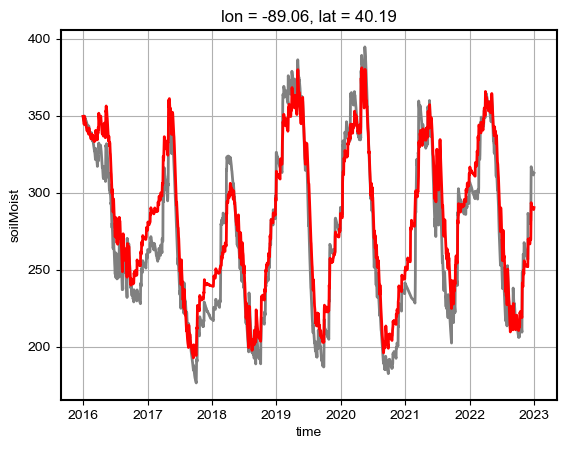

In [24]:
lat1, lon1 = 40.2,-89.1
# lat1, lon1 = 41.93255367319802, -95.74224906197333

fig, ax = plt.subplots()

ds_sim.soilMoist.sel(lat=lat1, lon=lon1, method='nearest').plot(lw=2, color='gray')
ds_obs.soilMoist.sel(lat=lat1, lon=lon1, method='nearest').plot(lw=2, color='red')

diff = ds_sim.soilMoist.sel(lat=lat1, lon=lon1, method='nearest') - ds_obs.soilMoist.sel(lat=lat1, lon=lon1, method='nearest')
rmse = np.sqrt((diff**2).mean(dim='time')).values

print(f"RMSE: {rmse}")

ax.grid()

plt.show()

RMSE: 17.401153564453125


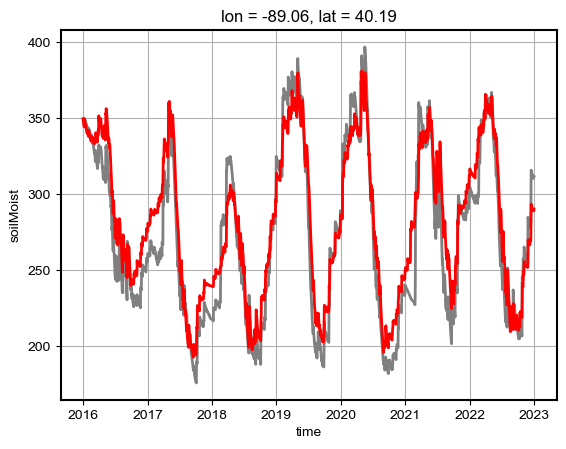

In [28]:
lat1, lon1 = 40.2,-89.1
# lat1, lon1 = 41.93255367319802, -95.74224906197333

fig, ax = plt.subplots()

ds_sim.soilMoist.sel(lat=lat1, lon=lon1, method='nearest').plot(lw=2, color='gray')
ds_obs.soilMoist.sel(lat=lat1, lon=lon1, method='nearest').plot(lw=2, color='red')

diff = ds_sim.soilMoist.sel(lat=lat1, lon=lon1, method='nearest') - ds_obs.soilMoist.sel(lat=lat1, lon=lon1, method='nearest')
rmse = np.sqrt((diff**2).mean(dim='time')).values

print(f"RMSE: {rmse}")

ax.grid()

plt.show()

In [39]:
ds_rmse.mean()

<xarray.DataArray 'soilMoist' ()>
array(33.53141, dtype=float32)

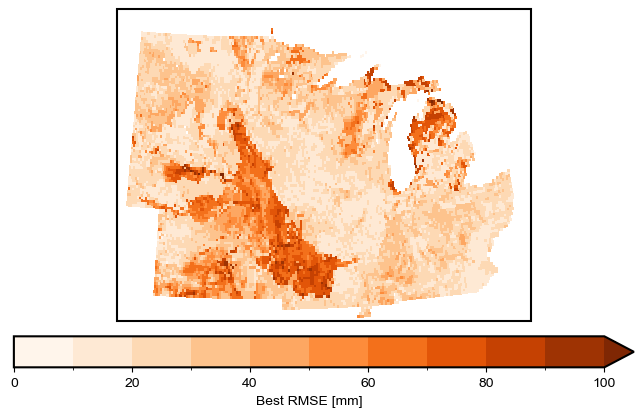

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

ds_rmse = np.sqrt(((ds_sim.soilMoist - ds_obs.soilMoist)**2).mean(dim='time'))
p = ds_rmse.plot(ax=ax, vmin=0, vmax=100, add_colorbar=False, levels=11, cmap = "Oranges", transform=ccrs.PlateCarree())

fig.colorbar(p,
             orientation="horizontal",
             label="Best RMSE [mm]",
             ax=ax,
             pad=0.04)

plt.show()

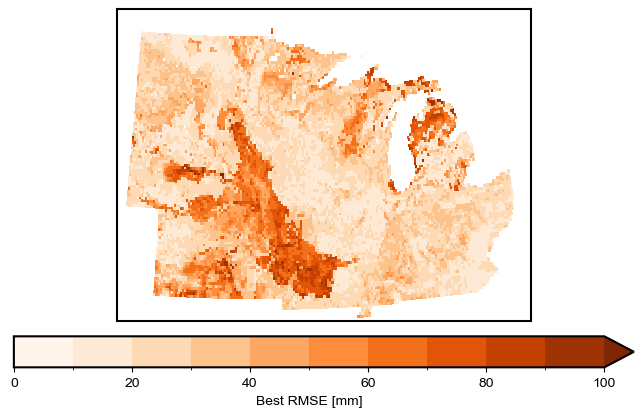

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

ds_rmse = np.sqrt(((ds_sim.soilMoist - ds_obs.soilMoist)**2).mean(dim='time'))
p = ds_rmse.plot(ax=ax, vmin=0, vmax=100, add_colorbar=False, levels=11, cmap = "Oranges", transform=ccrs.PlateCarree())

fig.colorbar(p,
             orientation="horizontal",
             label="Best RMSE [mm]",
             ax=ax,
             pad=0.04)

plt.show()